# Power

This notebook contains code to assess power and determine the optimal $n\_\{variable\}$ in an experiment. 

There are **two** ways of doing this:
1. [Simulation based approach](#simulation-based-approach)\
See the [description](#description-of-simulation-based-approach) below.

2. [Numerically estimation power](#numerical-power-estimation)\
See the [description](#description-of-numerical-power-estimation) below.

## Recommendations
1. Please ensure that you have install `wiscs`. 
2. Read the descriptions in the markdown cells carefully.

## Imports

In [13]:
import mixedpower as mp # type: ignore

import wiscs
from wiscs.simulate import DataGenerator
from wiscs.utils import make_tasks

from src.power import WISCSPowerCalculator

import warnings
warnings.filterwarnings("ignore")

## Description of simulation based approach

A simulation based approach to calculating $n\_\{variable\}$ for an experiment is simple, but it involves a few steps.

1. First, data are generated in which the values for $n\_\{variable\}$ are at a reasonable maximum. In the case of WISCS, `n_participant, n_items` and `n_questions` are all set at `100`. 

2. Next a range of possible values for all variables is chosen. For example `possible_n_participants = range(5, 100 + 1, 10)`. This is done for each parameter.

3. A combination, $C$, of all possible values of parameters is then generated (See sample slice below).

|   | n_items | n_participants | n_questions |
|---|---------|----------------|-------------|
| 0 | 10      | 10             | 10          |
| 1 | 10      | 10             | 20          |
| 2 | 10      | 10             | 30          |
| 3 | 10      | 10             | 40          |
| 4 | 10      | 10             | 50          |
| 5 | 10      | 10             | 60          |
| 6 | 10      | 10             | 70          |
| 7 | 10      | 10             | 80          |
| 8 | 10      | 10             | 90          |
| 9 | 10      | 10             | 100         |

4. For every row in $C$, data are randomly sampled such that the number of participants, questions and items sampled correspond to the values in $C$.

5. A linear model is run with the sampled data. At this first model a counter, $T$ is set. 

6. If the $\textit{p}$-value for the desired effects is less than a prespecified decision criterion, $\alpha$, then $T$ is increased by $1$.

7. Desired power is reached when $\frac{T}{\texttt{len}(C)} = \text{desired power}$. 

See [here](https://cran.r-project.org/web/packages/SimEngine/vignettes/example_1.html#:~:text=The%20basic%20idea%20is%20that,this%20is%20your%20estimated%20power.) for more details.

## Let's generate some data

See [generate_data.ipynb](/notebooks/generate_data.ipynb) for details regarding how data are generated.

In [30]:
task = make_tasks(200, 245, 100)

params = {
    'word.concept': 200,
    'image.concept': 175,
    'word.task': task,
    'image.task': task,
    'var.image': 30,
    'var.word': 20,
    'var.question': 20,
    'var.participant': 30,
    'n.participant': 100,
    'n.question': 100,
    'n.trial': 100,
    'design': {'items': 'within'}

}
wiscs.set_params(params)

Params set successfully


In [31]:
DG = DataGenerator()
df = DG.fit_transform().to_pandas() # need to convert data into a pandas dataframe, `wiscs` does this automatically with `.to_pandas()`

We now need to define a possible range of $n\_\{variable\}$. 

In [14]:
# If you wish to define a possible range of n_{variable}, modify + run this cell

#################################################################
n_participants_range = range(10, params["n.participant"] + 1, 10)
n_questions_range = range(10, params["n.question"] + 1, 10)
n_items_range = range(10, params["n.question"] + 1, 10)
#################################################################

## Simulation based approach

A specialized module, `src.WISCSPowerCalculator` has been created to handle the simulation based approach to calculating power. It handles all the steps outlined in the [description](#description-of-simulation-based-approach). 

The class is internally structured as follows:

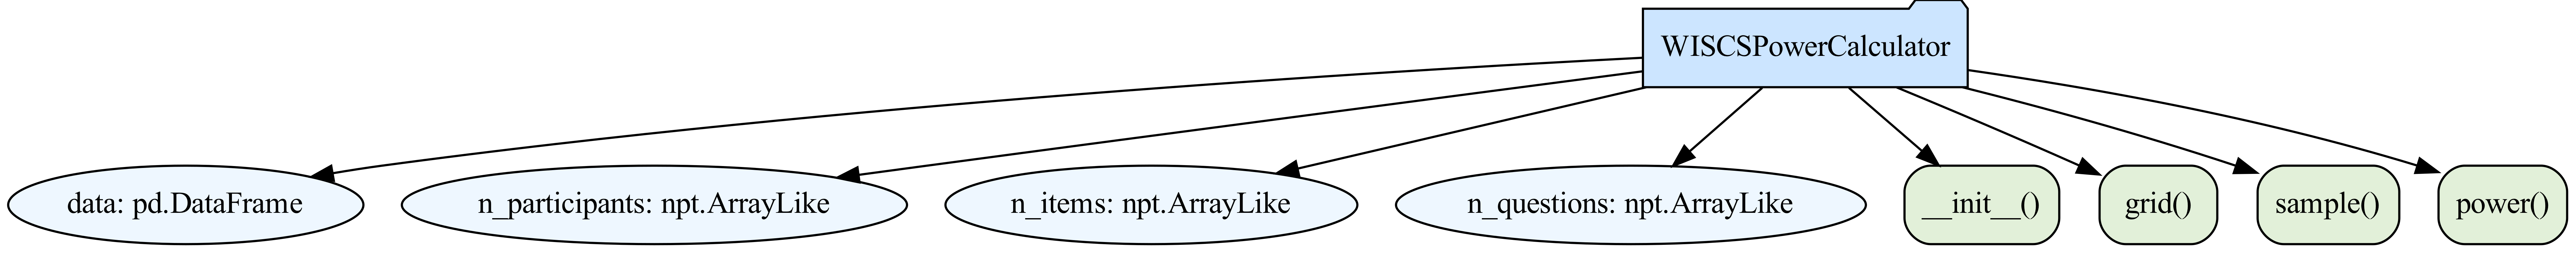

However, the user only interacts with `.power()`. Below is an example of how to use `src.WISCSPowerCalculator`.

In [17]:
# to instantiate the power calculator, run this cell

P = WISCSPowerCalculator(data=df, n_participants=n_participants_range, 
                         n_questions=n_questions_range, n_items=n_items_range)

The class requires as input a dataset from which to sample and arrays of values for each variable. To calculate power, one must simply call the `.power()` methods. 

`.power()` requires as input a value for desired power, alpha ($\alpha$) and then various inputs for [`statsmodels`](https://www.statsmodels.org/dev/mixed_glm.html). Note that `variable=` should be the effect of interest. In this case, $n\_\{variable\}$ is being determined based on the interaction between modality and question. 

In [10]:
# to determine the minimum n_{variable} required to achieve a desired power, modify + run this cell

#######################################################################
slice, power = P.power(desired_power=0.1, # <-- CHANGE THIS AS NEEDED
                                 alpha=0.05, # <-- CHANGE THIS AS NEEDED
                                 formula="rt ~ modality * question", # <-- CHANGE THIS AS NEEDED | For example, "rt ~ modality"
                                 variable="modality[T.word]:question", # <-- CHANGE THIS AS NEEDED | For example, "modality[T.word]"
                                 re_formula="~subject + question + item" # <-- CHANGE THIS AS NEEDED 
                                 ) 
#######################################################################

 13%|█▎        | 130/1000 [01:29<10:01,  1.45it/s, Power=0.1, Count=100] 


In [33]:
# to print out a "formatted" result, run this cell

print(f'n_participants:{slice[0]} \n n_questions:{slice[1]} \n n_items:{slice[2]} \n power:{power}')

n_participants:20 
 n_questions:40 
 n_items:10 
 power:0.1


## Description of numerical power estimation

Here, $n\_\{variable\}$ is solved numerically. This makes use of [`mixedpower`](https://github.com/w-decker/mixedpower) a python library for estimating power in mixed effects models. In short, this library is simply a Python conversion of [Jake Westfall's code](https://github.com/jake-westfall/two_factor_power/tree/master). 

In short, power is estimatied using a noncentrality parameter, $t$ and various variance components to estimate degrees of freedom and in turn, calculate power.

You can also solve for $n\_\{variable\}$. This is done by determing which value of $n\_\{variable\}$ minimized the squared error between desired power and the empirical power using that value for $n\_\{variable\}$. 

## Numerical power estimation

In [35]:
# to solve for n_participants, modify + run this cell 

###############################
args = dict(
    p=0.8, # desired power
    cohens_d = 0.5,
    resid=0.3,
    target_intercept=0.2,
    participant_intercept=0.2,
    participant_x_target = 0.1,
    target_slope=0.1,
    participant_slope=0.1,
    n_targets = 30,
    code=1, 
    alpha=0.05,
)
###############################

###############################################################
n_participants, _ = mp.solve(variable='n_participants', **args) # <- CHANGE THIS AS NEEDED | variable='n_targets'
print(f'Number of participants: {n_participants}')
###############################################################

Number of participants: 25
